In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.display import HTML

import os
import itertools
import gc
import pickle
import random

import numpy as np
import pandas as pd
import pandas_summary as pds
import seaborn as sns

from zillow import *
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn_pandas import DataFrameMapper
from keras import backend as K

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
zdata = None

In [3]:
if zdata is not None:
    del zdata
    gc.collect()
zdata = DataLoader()

In [4]:
_ = zdata.preprocessed.training()

# Common Functions

In [4]:
dropcols = set([
            'propertyzoningdesc', 
            'propertycountylandusecode', 
            'censustractandblock',
            'rawcensustractandblock',
            'parcelid',
           ])

def train_test_split(df, month):
    c = 'transaction_month'
    valid = df[df[c].astype('int') >= month]
    train = df[df[c].astype('int') < month]
#     return df[df[c] == month], df[df[c] != month], valid
    return train, valid

def remove_outliers(X, y, ycol='logerror'):
    # return X, y
    t = zdata.preprocessed.transactions()
    l_min = t[ycol].quantile(.05)
    l_max = t[ycol].quantile(.95)
    f = (y >= l_min) & (y <= l_max)
    return X[f], y[f]

def adapt(df, dropcols=set()):
    mustdropcols = set([
                'propertyzoningdesc', 
                'propertycountylandusecode', 
                'censustractandblock',
                'rawcensustractandblock',
                'parcelid',
               ])

    mustdropcols = mustdropcols | set(dropcols)
    df = df.drop(mustdropcols, axis=1)

    for c in df.columns:
        if df[c].dtype.name == 'object':
            df[c] = df[c].astype(np.float32)

    return df

# XGBoost

In [8]:
params = {
    'eta': 0.005,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'max_depth': 8,
    'silent': 1,
    'subsample': 0.5,
    'colsample_bytree': 0.2,
    'min_child_weight': 8,
    'lambda': 2,
}

train = zdata.preprocessed.training()

x_train = train.drop(['logerror', 'logerror_abs', 'logerror_percent'], axis=1)
y_train = train['logerror']

x_train, y_train = remove_outliers(x_train, y_train)

d_train = xgb.DMatrix(adapt(x_train), label=y_train, silent=True)

del x_train, y_train; gc.collect()

watchlist = [(d_train, 'train')]
evals_result = {}
# hist = xgb.cv(params, d_train, 600, nfold=10, early_stopping_rounds=1, verbose_eval=100)
clf = xgb.train(params, d_train, 10000, watchlist, evals_result=evals_result, 
                     early_stopping_rounds=1, verbose_eval=100)

del d_train; gc.collect()

[0]	train-mae:0.490179
Will train until train-mae hasn't improved in 1 rounds.
[100]	train-mae:0.29695
[200]	train-mae:0.179899
[300]	train-mae:0.110261
[400]	train-mae:0.072009
[500]	train-mae:0.052426
[600]	train-mae:0.043252
[700]	train-mae:0.039221
[800]	train-mae:0.037487
[900]	train-mae:0.036696
[1000]	train-mae:0.036293
[1100]	train-mae:0.036053
Stopping. Best iteration:
[1180]	train-mae:0.035921



21

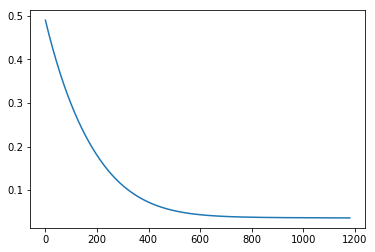

In [10]:
plt.plot(range(len(evals_result['train']['mae'])), evals_result['train']['mae'])

In [11]:
subm = pd.DataFrame()
months = [10, 11, 12, 22, 23, 24]
dates = ['201610', '201611', '201612', '201710', '201711', '201712']
for month, date in zip(months, dates):
    print('Predicting...', date)

    merged = zdata.preprocessed.prediction(month)
    subm['ParcelId'] = merged['parcelid']
    merged = adapt(merged)

    dm_test = xgb.DMatrix(merged)
    del merged; gc.collect()

    subm[date] = clf.predict(dm_test)
    del dm_test; gc.collect()

subm.to_csv('zillow/submission.xgb.csv.gz', index=False, float_format='%.4f', compression='gzip')

Predicting... 201610
Predicting... 201611
Predicting... 201612
Predicting... 201710
Predicting... 201711
Predicting... 201712


### Tuned MAE: 0.06472

# LightGBM

In [ ]:
import lightgbm as lgb

In [ ]:
##### RUN LIGHTGBM
params = {
    'learning_rate': 0.0025,
    'max_bin': 255,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l1',
    'num_leaves': 512,
    'bagging_fraction': 0.65,
    'bagging_freq': 40,
    'feature_fraction': 0.3,
    'min_data': 200,
    'min_hessian': 1,
#     'lambda_l2': 1,
    'verbose': 1,
    'num_threads': 3,
}

train = zdata.preprocessed.training()

x_train = train.drop(['logerror', 'logerror_abs', 'logerror_percent'], axis=1)
y_train = train['logerror']

x_train, y_train = remove_outliers(x_train, y_train)
del train; gc.collect()

categoricals = set(x_train.select_dtypes(include=['object']).columns) - dropcols

d_train = lgb.Dataset(adapt(x_train), label=y_train)
del x_train, y_train; gc.collect()

print("\nFitting LightGBM model ...")
clf = lgb.train(params, d_train, 1000, categorical_feature=categoricals, valid_sets=[d_train], early_stopping_rounds=1, verbose_eval=100)
# lgb.cv(params, d_train, 10000, nfold=4, early_stopping_rounds=10, verbose_eval=100)

del d_train; gc.collect()


Fitting LightGBM model ...


/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/lightgbm/basic.py:988: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['airconditioningtypeid', 'architecturalstyletypeid', 'block', 'buildingclasstypeid', 'buildingqualitytypeid', 'decktypeid', 'fips', 'heatingorsystemtypeid', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'storytypeid', 'tract', 'transaction_month', 'typeconstructiontypeid', 'yearbuilt']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1 rounds.
[100]	training's l1: 0.0372145
[200]	training's l1: 0.0368215
[300]	training's l1: 0.0364727
[400]	training's l1: 0.0361532
[500]	training's l1: 0.0358948
[600]	training's l1: 0.0356525
[700]	training's l1: 0.0354306
[800]	training's l1: 0.0352306
[900]	training's l1: 0.0350364
[1000]	training's l1: 0.0348375


0.0368519 + 0.00012879

In [8]:
subm = pd.DataFrame()
months = [10, 11, 12, 22, 23, 24]
dates = ['201610', '201611', '201612', '201710', '201711', '201712']
for month, date in zip(months, dates):
    print('Predicting...', date)

    merged = zdata.preprocessed.prediction(month)
    subm['ParcelId'] = merged['parcelid']
    merged = adapt(merged)

    subm[date] = clf.predict(merged)
    del merged; gc.collect()

subm.to_csv('zillow/submission.lgb.csv.gz', index=False, float_format='%.4f', compression='gzip')

Predicting... 201610
Predicting... 201611
Predicting... 201612
Predicting... 201710
Predicting... 201711
Predicting... 201712


# Neural Network

In [4]:
dropcols = ['censustractandblock', 'rawcensustractandblock', 'propertyzoningdesc', 'parcelid', 'calculatedbathnbr']
ycols = ['logerror', 'logerror_abs', 'logerror_percent']

t = zdata.preprocessed.training().drop(dropcols, axis=1)

cat_cols = t.select_dtypes(include=['object']).columns
cat_maps = [(c, LabelEncoder()) for c in cat_cols]
cat_mapper = DataFrameMapper(cat_maps)

con_cols = set(t.select_dtypes(exclude=['object']).columns) - set(ycols)
con_maps = [([c], StandardScaler()) for c in con_cols]
con_mapper = DataFrameMapper(con_maps)

In [5]:
def split_train(df, month):
    c = 'transaction_month'
    valid = df[df[c].astype('int') >= 10]
    train = df[df[c].astype('int') < 10]
#     return df[df[c] == month], df[df[c] != month], valid
    return train, valid

def feature_split(df):
    return np.split(df, df.shape[1], axis=1)

def remove_outliers(X, y, ycol='logerror'):
    # return X, y
    t = zdata.preprocessed.transactions()
    l_min = t[ycol].quantile(.05)
    l_max = t[ycol].quantile(.95)
    f = (y >= l_min) & (y <= l_max)
    return X[f], y[f]

class NeuralThread:
    def __init__(self, inp, layers, units, outputs):
        self.units = units
        self.input = inp
        self.dense = [ Dense(units, activation='relu', kernel_initializer='random_uniform') for l in range(layers) ]
        b = BatchNormalization()(inp)
        din = b
        for d in self.dense:
#             d.trainable = False
            din = d(din)
        self.out = Dense(outputs, activation='linear', kernel_initializer='random_uniform')
#         self.out.trainable = False
        self.output = self.out(din)
        
    def set_trainable(self, trainable):
        for d in self.dense: 
            d.trainable = trainable
        self.out.trainable = trainable

def build_neural_network(cat_map_fit, con_map_fit):
    embsz = 16
    
    def categorical_input(fname, fclasses):
        vocsz = len(fclasses)
        inp = Input((1,), dtype='int64', name=fname+'_inp')
#         emb_init = keras.initializers.RandomUniform(minval=-0.06/embsz, maxval=0.06/embsz)
        out = Embedding(vocsz, embsz, input_length=1)(inp)
        out = Flatten(name=fname+'_flt')(out)
#         out = Dense(1, name=fname+'_den', activation='hard_sigmoid', use_bias=False, kernel_initializer='ones')(out)
        return inp, out

    def continuous_input(fname):
        inp = Input((1,), dtype='float32', name=fname+'_inp')
#         out = Dense(1, name=fname+'_den', activation='hard_sigmoid', use_bias=False, kernel_initializer='ones')(inp)
        return inp, inp

    def dense_stack(inp, layers, units, dropout):
#         den = Dropout(dropout)(inp)
        for i in range(layers):
            den = Dense(units, activation='relu', kernel_initializer='random_uniform')(inp)
        den = Dense(1, activation='linear')(den)
        return den

    def dense_weave(inp, threads, layers, units, dropout=0.02):
        return [ dense_stack(inp, layers, units, dropout) for t in range(threads) ] 

    cat_in = [ categorical_input(f[0], f[1].classes_) for f in cat_map_fit.features ]
    con_in = [ continuous_input(f[0][0]) for f in con_map_fit.features ]
    all_in = concatenate([ o for _, o in cat_in ] + [ o for _, o in con_in ])
    t = NeuralThread(all_in, 2, 128, 128)
    n = concatenate([ t.output, all_in ])
    t = NeuralThread(n, 2, 128, 128)
    n = concatenate([ t.output, all_in ])
    t = NeuralThread(n, 2, 128, 128)
    n = concatenate([ t.output, all_in ])
#     t = NeuralThread(n, 2, 128, 128)
#     n = concatenate([ t.output, all_in ])
    t = NeuralThread(n, 2, 128, 1)
    den = t.output
    
#     threads = [ NeuralThread(den, 2, 4) for i in range(1) ] + \
#         [ NeuralThread(den, 2, 8) for i in range(1) ] + \
#         [ NeuralThread(den, 2, 16) for i in range(1) ] + \
#         [ NeuralThread(den, 2, 32) for i in range(1) ] + \
#         [ NeuralThread(den, 2, 64) for i in range(1) ]
    
#     den = add([ t.output for t in threads ])
#     den = Dense(1, activation='linear')(den)

    model = Model(inputs=[ i for i, _ in cat_in ] + [ i for i, _ in con_in ], outputs=[den])
    
    return model

In [18]:
train, valid = split_train(t, 9)
x_train, y_train = train, train['logerror']
x_train, y_train = remove_outliers(x_train, y_train)
x_valid, y_valid = valid.drop('logerror', axis=1), valid['logerror']
con_map_fit = con_mapper.fit(x_train)
cat_map_fit = cat_mapper.fit(zdata.preprocessed.properties())
train_features = np.concatenate([cat_map_fit.transform(x_train), con_map_fit.transform(x_train)], axis=1)
valid_features = np.concatenate([cat_map_fit.transform(x_valid), con_map_fit.transform(x_valid)], axis=1)

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype bool was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
# train, valid = split_train(t, 9)
x_train, y_train = t, t['logerror']
x_train, y_train = remove_outliers(x_train, y_train)
# x_valid, y_valid = valid.drop('logerror', axis=1), valid['logerror']
con_map_fit = con_mapper.fit(x_train)
cat_map_fit = cat_mapper.fit(zdata.preprocessed.properties())
train_features = np.concatenate([cat_map_fit.transform(x_train), con_map_fit.transform(x_train)], axis=1)
# valid_features = np.concatenate([cat_map_fit.transform(x_valid), con_map_fit.transform(x_valid)], axis=1)

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype bool was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
model = build_neural_network(cat_map_fit, con_map_fit)
model.summary()
gc.collect()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
airconditioningtypeid_inp (Input (None, 1)             0                                            
____________________________________________________________________________________________________
architecturalstyletypeid_inp (In (None, 1)             0                                            
____________________________________________________________________________________________________
buildingclasstypeid_inp (InputLa (None, 1)             0                                            
____________________________________________________________________________________________________
buildingqualitytypeid_inp (Input (None, 1)             0                                            
___________________________________________________________________________________________

8

In [8]:
opt = keras.optimizers.Adam(lr=0.001, decay=0.025)
model.compile(loss='mean_absolute_error', optimizer=opt)
hist = model.fit(feature_split(train_features), y_train, batch_size=64, epochs=4,
             verbose=1, shuffle=True)

Epoch 1/4
81252/81252 [==============================] - 23s - loss: 0.0375    
Epoch 2/4
81252/81252 [==============================] - 21s - loss: 0.0367    
Epoch 3/4
81252/81252 [==============================] - 21s - loss: 0.0364    
Epoch 4/4
81252/81252 [==============================] - 20s - loss: 0.0362    


In [9]:
del train_features, x_train, y_train, t; gc.collect()

241

In [10]:
subm = pd.DataFrame()
months = [10, 11, 12, 22, 23, 24]
dates = ['201610', '201611', '201612', '201710', '201711', '201712']
for month, date in zip(months, dates):
    print('Constructing prediction set...', date)
    merged = zdata.preprocessed.prediction(month)
    subm['ParcelId'] = merged['parcelid']
    merged = merged.drop(dropcols, axis=1)
    merged = np.concatenate([cat_map_fit.transform(merged), con_map_fit.transform(merged)], axis=1)
    print('Predicting...', date)
    subm[date] = model.predict(feature_split(merged))
    subm.to_csv('zillow/submission.nn.{}.csv.gz'.format(month), index=False, float_format='%.4f', compression='gzip')
    del merged; gc.collect()

subm.to_csv('zillow/submission.nn.csv.gz', index=False, float_format='%.4f', compression='gzip')

Predicting... 201610


/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype bool was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Predicting... 201611
Predicting... 201612
Predicting... 201710
Predicting... 201711
Predicting... 201712


In [13]:
wgt_x = 0.6
wgt_l = 0.3
wgt_n = 1 - wgt_l - wgt_x

xsub = pd.read_csv('zillow/submission.xgb.csv.gz').set_index('ParcelId')
lsub = pd.read_csv('zillow/submission.lgb.csv.gz').set_index('ParcelId')
nsub = pd.read_csv('zillow/submission.nn.csv.gz').set_index('ParcelId')

esub = xsub * wgt_x + lsub * wgt_l + nsub * wgt_n
esub.to_csv('zillow/submission.ens.csv.gz', index=True, float_format='%.4f', compression='gzip')

# Neural Encoding of Categories

In [5]:
dropcols = ['censustractandblock', 'rawcensustractandblock', 'propertyzoningdesc', 'parcelid']
ycols = ['logerror', 'logerror_abs', 'logerror_percent']

t = zdata.preprocessed.training().drop(dropcols, axis=1)

cat_cols = t.select_dtypes(include=['object']).columns
cat_maps = [(c, LabelEncoder()) for c in cat_cols]
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(t)


con_cols = set(t.select_dtypes(exclude=['object']).columns) - set(ycols)
con_maps = [([c], MinMaxScaler()) for c in con_cols]
con_mapper = DataFrameMapper(con_maps)

In [5]:
# Just check if categorical values are equally represented throughout each month
#
# NOPE, but maybe it won't matter
#
c = t.transaction_month
uniques = pd.DataFrame()
uniques['col'] = cat_cols
for m in range(1, 10):
    for col in cat_cols:
        uniques.loc[uniques.col==col, m] = len(t.loc[c == m, col].unique())
uniques

,col,1,2,3,4,5,6,7,8,9
0,airconditioningtypeid,5.0,5.0,5.0,5.0,7.0,5.0,5.0,5.0,5.0
1,architecturalstyletypeid,4.0,3.0,5.0,6.0,3.0,6.0,3.0,4.0,4.0
2,buildingclasstypeid,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0
3,buildingqualitytypeid,6.0,7.0,7.0,7.0,8.0,6.0,7.0,6.0,6.0
4,decktypeid,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
5,heatingorsystemtypeid,9.0,10.0,8.0,9.0,10.0,10.0,10.0,10.0,9.0
6,pooltypeid10,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
7,pooltypeid2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
8,pooltypeid7,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
9,propertycountylandusecode,41.0,44.0,50.0,42.0,47.0,45.0,45.0,46.0,47.0


In [10]:
def split_train(df, month):
    c = 'transaction_month'
    valid = df[df[c].astype(int) >= 10]
    df = df[df[c].astype(int) < 10]
#     return df[df[c] == month], df[df[c] != month], valid
    return df, df, valid

def build_neural_encoder(mapper, embsz, outsz):
    def categorical_input(fname, fclasses):
        vocsz = len(fclasses)
        inp = Input((1,), dtype='int64', name=fname+'_inp')
        emb_init = keras.initializers.RandomUniform(minval=0, maxval=1)
        out = Embedding(vocsz, embsz, input_length=1, embeddings_initializer=emb_init)(inp)
        out = Flatten(name=fname+'_flt')(out)
        out = Dense(1, name=fname+'_den', activation='relu', use_bias=False, kernel_initializer='ones')(out)
        return inp, out

    cat_in = [ categorical_input(f[0], f[1].classes_) for f in mapper.features ]
    
    den = concatenate([ o for _, o in cat_in ])
    den = Dropout(0.3)(den)
    den = Dense(outsz, activation='relu', kernel_initializer='random_uniform')(den)
    enc = Dense(outsz, activation='relu', kernel_initializer='random_uniform', name='encoder_out')(den)
    out = Dense(1, activation='linear')(enc)

    model = Model(inputs=[ i for i, _ in cat_in ], outputs=[out])
    opt = keras.optimizers.Adam(lr=0.001, decay=0.01)
    model.compile(loss='mean_absolute_error', optimizer=opt)
    return model

def feature_split(df):
    return np.split(df, df.shape[1], axis=1)

def remove_outliers(X, y, ycol='logerror'):
    # return X, y
    t = zdata.preprocessed.transactions()
    l_min = t[ycol].quantile(.05)
    l_max = t[ycol].quantile(.95)
    f = (y >= l_min) & (y <= l_max)
    return X[f], y[f]

def train_neural_encoder(mapper, train, valid):
#     x_train, y_train = remove_outliers(train, train['logerror'])
    x_train, y_train = train, train['logerror']  
    x_valid, y_valid = valid.drop('logerror', axis=1), valid['logerror']
    train_features = mapper.transform(x_train)
    valid_features = mapper.transform(x_valid)
    model = build_neural_encoder(mapper, 16, 256)
    hist = model.fit(feature_split(train_features), y_train, batch_size=64, epochs=10,
                     verbose=0, validation_data=(feature_split(valid_features), y_valid), shuffle=True)
    inp = [ model.layers[l].input for l in range(len(cat_map_fit.features)) ] + [ K.learning_phase() ]
    out = [ model.layers[-5].output ]
    encode = K.function(inp, out)
    return encode, model, hist

def transform_train(cat_map_fit, cat_encode, con_map_fit, train):
    cat_features = cat_map_fit.transform(train)
    learning_phase = np.zeros((cat_features.shape[0], 1))
    cat_features = feature_split(cat_features)
    cat_features.append(0)
#     print(cat_features.shape)
    cat_encoded = pd.DataFrame(cat_encode(cat_features)[0])
    con_features = con_map_fit.transform(train)
    return np.concatenate([cat_encoded, con_features], axis=1)

In [21]:
train = t[t.transaction_month < 10]
valid = t[t.transaction_month >= 10]
cat_encode, model, hist = train_neural_encoder(cat_map_fit, train, valid)

KeyboardInterrupt: 

In [21]:
hist.history

{'loss': [0.03772509381298652,
  0.037629551577563598,
  0.037572324590265709,
  0.037525312321103142,
  0.037524054713758484,
  0.037507766462518508,
  0.037499537158352421,
  0.037473359470981189,
  0.03749485812413058,
  0.037503994171301028],
 'val_loss': [0.065963704858583189,
  0.065881870864942627,
  0.065888426955453522,
  0.065908982390348148,
  0.065940857012094359,
  0.065901859143360303,
  0.065945088169078472,
  0.065920364156145592,
  0.065895236447694239,
  0.065916894441171769]}

In [7]:
def train_xgb(month):
    cat_train, train, valid = split_train(t, 1)
    con_map_fit = con_mapper.fit(train)

    cat_encode, model, hist = train_neural_encoder(cat_map_fit, cat_train, valid)

    x_train = transform_train(cat_map_fit, cat_encode, con_map_fit, train)
    y_train = train['logerror']

    x_train, y_train = remove_outliers(x_train, y_train)

    x_valid = transform_train(cat_map_fit, cat_encode, con_map_fit, valid)
    y_valid = valid['logerror']

    d_train = xgb.DMatrix(x_train, label=y_train, silent=True)
    d_valid = xgb.DMatrix(x_valid, label=y_valid, silent=True)

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    evals_result = {}
    clf = xgb.train(params, d_train, 10000, watchlist, evals_result=evals_result, 
                         early_stopping_rounds=200, verbose_eval=None)
    
    del x_train, y_train, x_valid, y_valid, d_train, d_valid; gc.collect()
    
    print (clf.attributes()['best_msg'])
    return clf, cat_encode, con_map_fit

In [12]:
params = {
    'eta': 0.005,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'max_depth': 8,
    'silent': 1,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'min_child_weight': 9,
    'lambda': 2,
}

In [15]:
y_mean = zdata.transactions()['logerror'].mean()

In [34]:
params = {
    'eta': 0.005,
    'max_depth': 8,
    'subsample': 0.5,
    'colsample_bytree': 0.5,    
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda': 2,
    'min_child_weight': 9,
#     'base_score': y_mean,
    'silent': 1
}

In [35]:
train_xgb(1)

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype bool was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[1007]	train-mae:0.035984	valid-mae:0.064839


(<xgboost.core.Booster at 0x7f57dbe209b0>,
 DataFrameMapper(default=False, df_out=False,
         features=[(['taxdelinquencyyear_age'], MinMaxScaler(copy=True, feature_range=(0, 1))), (['distance_fips'], MinMaxScaler(copy=True, feature_range=(0, 1))), (['bedroomcnt'], MinMaxScaler(copy=True, feature_range=(0, 1))), (['calculatedfinishedsquarefeet'], MinMaxScaler(copy=True, feature_range=(0, 1))...y=True, feature_range=(0, 1))), (['hashottuborspa'], MinMaxScaler(copy=True, feature_range=(0, 1)))],
         input_df=False, sparse=False))

In [8]:
clfs = [ train_xgb(m) for m in range(5, 10) ]

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype bool was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[2729]	train-mae:0.035078	valid-mae:0.064732
[2704]	train-mae:0.035092	valid-mae:0.064769
[2845]	train-mae:0.035027	valid-mae:0.064773
[3252]	train-mae:0.03478	valid-mae:0.064741
[3413]	train-mae:0.034708	valid-mae:0.064725


In [10]:
test = t[t['transaction_month'] >= 10]
y_test = test['logerror']

i = 0
preds = pd.DataFrame()
for clf, cat_encode, con_map_fit in clfs:
    x_test = transform_train(cat_map_fit, cat_encode, con_map_fit, test)
    d_test = xgb.DMatrix(x_test)
    preds[str(i)] = clf.predict(d_test)
    i += 1

In [11]:
mean_absolute_error(preds.mean(axis=1), y_test)

0.06476419960138341

In [9]:
i = 4
for clf, cat_encode, con_map_fit in clfs:
    subm = pd.DataFrame()
    months = [10, 11, 12, 22, 23, 24]
    dates = ['201610', '201611', '201612', '201710', '201711', '201712']
#     months = [10]
#     dates = ['201610']
    for month, date in zip(months, dates):
        print('Predicting...', date)

        merged = zdata.preprocessed.prediction(month)
        subm['ParcelId'] = merged['parcelid']
        
        merged = transform_train(cat_map_fit, cat_encode, con_map_fit, merged)
        dm_test = xgb.DMatrix(merged)
        del merged; gc.collect()

        subm[date] = clf.predict(dm_test)
        del dm_test; gc.collect()

    subm.to_csv('zillow/submission_clf{}.csv.gz'.format(i), index=False, float_format='%.4f', compression='gzip')
    i += 1

Predicting... 201610
Predicting... 201611
Predicting... 201612
Predicting... 201710
Predicting... 201711
Predicting... 201712
Predicting... 201610
Predicting... 201611
Predicting... 201612
Predicting... 201710
Predicting... 201711
Predicting... 201712
Predicting... 201610
Predicting... 201611
Predicting... 201612
Predicting... 201710
Predicting... 201711
Predicting... 201712
Predicting... 201610
Predicting... 201611
Predicting... 201612
Predicting... 201710
Predicting... 201711
Predicting... 201712
Predicting... 201610
Predicting... 201611
Predicting... 201612
Predicting... 201710
Predicting... 201711
Predicting... 201712


In [10]:
subm = pd.read_csv('zillow/submission_clf0.csv.gz').set_index('ParcelId')
for i in range(1, 9):
    subm = subm + pd.read_csv('zillow/submission_clf{}.csv.gz'.format(i)).set_index('ParcelId')
subm = subm / 9
subm.to_csv('zillow/submission_clf.csv.gz', index=True, float_format='%.4f', compression='gzip')

In [ ]:
to_pickle(cat_map_fit, 'zillow/cat_map_fit.pkl')
i = 0
for clf, cat_encode, con_map_fit in clfs:
    to_pickle(cat_map_fit, 'zillow/cat_map_fit.pkl')

# Experiments

In [4]:
zdata.transactions()['logerror'].describe()

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64

In [12]:
t = zdata.transactions()

In [13]:
t.loc[t.logerror.abs() <= 2*t.logerror.std(), ['logerror']].describe()

,logerror
count,87583.000000
mean,0.006514
std,0.075046
min,-0.321600
25%,-0.025300
50%,0.005000
75%,0.036300
max,0.322100


,logerror
count,88473.000000
mean,0.009362
std,0.083449
min,-0.342500
25%,-0.025300
50%,0.006000
75%,0.038300
max,0.463700


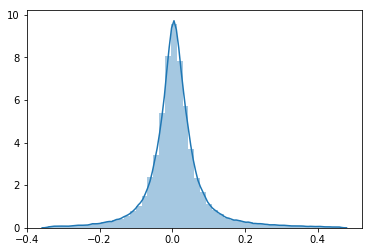

In [38]:
c = 'logerror'
e_min = t[c].quantile(0.01)
e_max = t[c].quantile(0.99)
no_outliers = t.loc[(t[c] >= e_min) & (t[c] <= e_max), ['logerror']]
sns.distplot(no_outliers)
no_outliers.describe()

,logerror,logerror_exp,error_percentage
count,90275.000000,90275.000000,90275.000000
mean,0.011457,1.032591,3.259076
std,0.161079,0.711017,71.101716
min,-4.605000,0.010002,-98.999830
25%,-0.025300,0.975017,-2.498264
50%,0.006000,1.006018,0.601804
75%,0.039200,1.039978,3.997846
max,4.737000,114.091414,11309.141351


,logerror,logerror_exp,error_percentage
0.025,-0.2021,0.817013,-18.298678
0.975,0.2700,1.309964,30.996445


,logerror,logerror_exp,error_percentage
0.01,-0.342500,0.709993,-29.000688
0.99,0.463882,1.590235,59.023539


,logerror,logerror_exp,error_percentage
count,88473.000000,88473.000000,88473.000000
mean,0.009362,1.013007,1.300687
std,0.083449,0.088097,8.809690
min,-0.342500,0.709993,-29.000688
25%,-0.025300,0.975017,-2.498264
50%,0.006000,1.006018,0.601804
75%,0.038300,1.039043,3.904290
max,0.463700,1.589946,58.994592


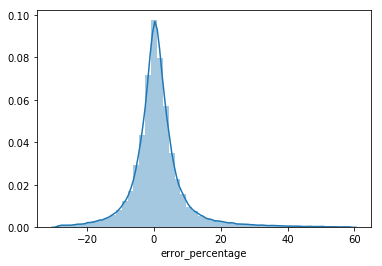

In [40]:
e = pd.DataFrame(t['logerror'])
e['logerror_exp'] = np.exp(t['logerror'])
e['error_percentage'] = (e['logerror_exp']-1)*100
display(e.describe())
display(e.quantile([0.025, 0.975]))
display(e.quantile([0.01, 0.99]))
c = 'error_percentage'
e_min = e[c].quantile(.01)
e_max = e[c].quantile(.99)
# sns.distplot(e[c])
e_no_outliers = e[(e.error_percentage >= e_min) & (e.error_percentage <= e_max)]
sns.distplot(e_no_outliers[c])
e_no_outliers.describe()

In [38]:
e_min = e.quantile(.01)[0]
e_max = e.quantile(.99)[0]
e.loc[(e.logerror >= e_min) & (e.logerror <= e_max), ['logerror']].describe()

e['error_percentage'].describe()

count    90275.000000
mean        -3.259076
std         71.101716
min     -11309.141351
25%         -3.997846
50%         -0.601804
75%          2.498264
max         98.999830
Name: error_percentage, dtype: float64

In [4]:
t = zdata.preprocessed.transactions()

In [9]:
c = 'logerror_percent'
e_min = t[c].quantile(.01)
e_max = t[c].quantile(.99)
t[(t[c] <= e_min) | (t[c] >= e_max)].groupby('transaction_month').count()

,parcelid,logerror,logerror_percent,logerror_abs
transaction_month,,,,
1,151,151,151,151
2,162,162,162,162
3,194,194,194,194
4,192,192,192,192
5,185,185,185,185
6,207,207,207,207
7,171,171,171,171
8,192,192,192,192
9,190,190,190,190


In [10]:
_ = xgb.predict()

Predicting... 201610
Predicting... 201611
Predicting... 201612
Predicting... 201710
Predicting... 201711
Predicting... 201712


In [5]:
def filter_columns(missing):
    vals = describe_values(zdata.properties())
    return set(vals.loc[vals['missing %'] > missing]['column'])
cols_high_missing = filter_columns(missing=90)
cols_high_missing

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.


{'architecturalstyletypeid',
 'basementsqft',
 'buildingclasstypeid',
 'decktypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fireplaceflag',
 'hashottuborspa',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'storytypeid',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'typeconstructiontypeid',
 'yardbuildingsqft17',
 'yardbuildingsqft26'}

In [6]:
params = {
    'eta': 0.005,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'max_depth': 3,
    'silent': 1,
    'subsample': 0.5,
    'colsample_bytree': 0.2,
    'min_child_weight': 4,
    'lambda': 2,
}

_ = xgb.train(params=params, verbose_eval=200, dropcols=cols_high_missing)

[0]	train-mae:0.490149	valid-mae:0.487114
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[200]	train-mae:0.186549	valid-mae:0.189346
[400]	train-mae:0.087376	valid-mae:0.09376
[600]	train-mae:0.061226	valid-mae:0.069789
[800]	train-mae:0.056029	valid-mae:0.065758
[1000]	train-mae:0.055017	valid-mae:0.065251
[1200]	train-mae:0.054765	valid-mae:0.065189
[1400]	train-mae:0.054662	valid-mae:0.065174
[1600]	train-mae:0.054604	valid-mae:0.065164
[1800]	train-mae:0.054559	valid-mae:0.065158
[2000]	train-mae:0.054518	valid-mae:0.065146
Stopping. Best iteration:
[1951]	train-mae:0.054527	valid-mae:0.065146

[1951]	train-mae:0.054527	valid-mae:0.065146


In [3]:
p = zdata.properties()
cln = pd.DataFrame()

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [30]:
c = 'airconditioningtypeid'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int').astype('str')
cln[c].unique()

array([ nan,   1.,  13.,   5.,  11.,   9.,  12.,   3.])

array(['0', '1', '13', '5', '11', '9', '12', '3'], dtype=object)

In [33]:
c = 'architecturalstyletypeid'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int').astype('str')
cln[c].unique()

array([ nan,   7.,  21.,   8.,   2.,   3.,   5.,  10.,  27.])

array(['0', '7', '21', '8', '2', '3', '5', '10', '27'], dtype=object)

In [121]:
summarize(p[['architecturalstyletypeid', 'airconditioningtypeid']])

,architecturalstyletypeid,airconditioningtypeid
count,6061,811519
mean,7.20261,1.93117
std,2.43629,3.14859
min,2,1
25%,7,1
50%,7,1
75%,7,1
max,27,13
counts,6061,811519
uniques,8,7


In [34]:
c = 'basementsqft'
cln[c] = p[c].fillna(0).astype('float32')

In [54]:
c = 'bathroomcnt'
display(p[c].unique())
cln[c] = p[c].fillna(p[c].mode()[0]).astype('float32')
cln[c].unique()
p[c].mode()[0]

array([  0.  ,   2.  ,   4.  ,   3.  ,   1.  ,   2.5 ,   3.5 ,   5.  ,
         1.5 ,   4.5 ,   7.5 ,   5.5 ,   6.  ,   7.  ,  10.  ,   8.  ,
         9.  ,  12.  ,  11.  ,   8.5 ,   6.5 ,  13.  ,   9.5 ,  14.  ,
        20.  ,  19.5 ,  15.  ,  10.5 ,    nan,  18.  ,  16.  ,   1.75,
        17.  ,  19.  ,   0.5 ,  12.5 ,  11.5 ,  14.5 ])

2.0

In [44]:
c = 'bedroomcnt'
display(p[c].unique())
cln[c] = p[c].fillna(p[c].mode()[0]).astype('int')
display(cln[c].unique())
p[c].mode()[0]

array([  0.,   4.,   5.,   2.,   3.,   1.,   6.,   7.,   8.,  12.,  11.,
         9.,  10.,  14.,  16.,  13.,  nan,  15.,  17.,  18.,  20.,  19.])

array([ 0,  4,  5,  2,  3,  1,  6,  7,  8, 12, 11,  9, 10, 14, 16, 13, 15,
       17, 18, 20, 19])

3.0

In [48]:
c = 'buildingclasstypeid'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int').astype('str')
display(cln[c].unique())

array([ nan,   3.,   4.,   5.,   2.,   1.])

array(['0', '3', '4', '5', '2', '1'], dtype=object)

In [49]:
c = 'buildingqualitytypeid'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int').astype('str')
display(cln[c].unique())

array([ nan,   7.,   4.,  10.,   1.,  12.,   8.,   3.,   6.,   9.,   5.,
        11.,   2.])

array(['0', '7', '4', '10', '1', '12', '8', '3', '6', '9', '5', '11', '2'], dtype=object)

In [77]:
c = 'calculatedbathnbr'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('float32')
display(cln[c].unique())
display(p[c].mode())

array([  nan,   2. ,   4. ,   3. ,   1. ,   2.5,   3.5,   5. ,   1.5,
         4.5,   7.5,   5.5,   6. ,   7. ,  10. ,   8. ,   9. ,  12. ,
        11. ,   8.5,   6.5,  13. ,   9.5,  14. ,  20. ,  19.5,  15. ,
        10.5,  18. ,  16. ,  17. ,  19. ,  12.5,  11.5,  14.5])

array([  0. ,   2. ,   4. ,   3. ,   1. ,   2.5,   3.5,   5. ,   1.5,
         4.5,   7.5,   5.5,   6. ,   7. ,  10. ,   8. ,   9. ,  12. ,
        11. ,   8.5,   6.5,  13. ,   9.5,  14. ,  20. ,  19.5,  15. ,
        10.5,  18. ,  16. ,  17. ,  19. ,  12.5,  11.5,  14.5])

0    2.0
dtype: float64

In [75]:
c = 'threequarterbathnbr'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int')
display(cln[c].unique())

array([ nan,   1.,   2.,   4.,   3.,   6.,   5.,   7.])

array([0, 1, 2, 4, 3, 6, 5, 7])

In [76]:
c = 'fullbathcnt'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int')
display(cln[c].unique())

array([ nan,   2.,   4.,   3.,   1.,   5.,   7.,   6.,  10.,   8.,   9.,
        12.,  11.,  13.,  14.,  20.,  19.,  15.,  18.,  16.,  17.])

array([ 0,  2,  4,  3,  1,  5,  7,  6, 10,  8,  9, 12, 11, 13, 14, 20, 19,
       15, 18, 16, 17])

In [80]:
cln.loc[cln.calculatedbathnbr != cln.fullbathcnt + cln.threequarterbathnbr/2, ['calculatedbathnbr']]

,calculatedbathnbr


In [86]:
summarize(cln.loc[cln.calculatedbathnbr != cln.bathroomcnt, ['calculatedbathnbr', 'bathroomcnt', 'fullbathcnt', 'threequarterbathnbr']])

,calculatedbathnbr,bathroomcnt,fullbathcnt,threequarterbathnbr
count,12298,12298,12298,12298
mean,0,2.03108,0,0
std,0,0.344945,0,0
min,0,0.5,0,0
25%,0,2,0,0
50%,0,2,0,0
75%,0,2,0,0
max,0,8.5,0,0
counts,12298,12298,12298,12298
uniques,1,12,1,1


In [82]:
summarize(cln[['calculatedbathnbr', 'bathroomcnt', 'fullbathcnt', 'threequarterbathnbr']])

,calculatedbathnbr,bathroomcnt,fullbathcnt,threequarterbathnbr
count,2.98522e+06,2.98522e+06,2.98522e+06,2.98522e+06
mean,2.19997,2.20834,2.14725,0.105436
std,1.08474,1.07576,1.07152,0.311161
min,0,0,0,0
25%,2,2,2,0
50%,2,2,2,0
75%,3,3,3,0
max,20,20,20,7
counts,2985217,2985217,2985217,2985217
uniques,35,37,21,8


In [89]:
c = 'decktypeid'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int').astype('str')
display(cln[c].unique())

array([ nan,  66.])

array(['0', '66'], dtype=object)

In [92]:
c = 'finishedfloor1squarefeet'
cln[c] = p[c].fillna(0).astype('float32')
c = 'calculatedfinishedsquarefeet'
cln[c] = p[c].fillna(0).astype('float32')
c = 'finishedsquarefeet12'
cln[c] = p[c].fillna(0).astype('float32')
c = 'finishedsquarefeet13'
cln[c] = p[c].fillna(0).astype('float32')
c = 'finishedsquarefeet15'
cln[c] = p[c].fillna(0).astype('float32')
c = 'finishedsquarefeet50'
cln[c] = p[c].fillna(0).astype('float32')
c = 'finishedsquarefeet6'
cln[c] = p[c].fillna(0).astype('float32')

In [93]:
c = 'fips'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int').astype('str')
display(cln[c].unique())

array([ 6037.,  6059.,  6111.,    nan])

array(['6037', '6059', '6111', '0'], dtype=object)

In [99]:
c = 'fireplacecnt'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int')
display(cln[c].unique())

array([ nan,   3.,   1.,   2.,   4.,   9.,   5.,   7.,   6.,   8.])

array([0, 3, 1, 2, 4, 9, 5, 7, 6, 8])

In [100]:
c = 'garagecarcnt'
display(p[c].unique())
cln[c] = p[c].fillna(p[c].mode()[0]).astype('int')
display(cln[c].unique())
display(p[c].mode())

array([ nan,   2.,   4.,   1.,   3.,   0.,   5.,   7.,   6.,   8.,   9.,
        12.,  11.,  10.,  13.,  14.,  15.,  25.,  21.,  18.,  17.,  24.,
        19.,  16.,  20.])

array([ 2,  4,  1,  3,  0,  5,  7,  6,  8,  9, 12, 11, 10, 13, 14, 15, 25,
       21, 18, 17, 24, 19, 16, 20])

0    2.0
dtype: float64

In [101]:
c = 'garagetotalsqft'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('float32')
display(cln[c].unique())
display(p[c].mode())

array([   nan,   420.,   525., ...,  2482.,  4568.,  1974.])

array([    0.,   420.,   525., ...,  2482.,  4568.,  1974.])

0    0.0
dtype: float64

In [102]:
c = 'hashottuborspa'
display(p[c].unique())
cln[c] = p[c] == True
display(cln[c].unique())
display(p[c].mode())

array([nan, True], dtype=object)

array([False,  True], dtype=bool)

0    True
dtype: object

In [104]:
c = 'heatingorsystemtypeid'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int').astype('str')
display(cln[c].unique())
display(p[c].mode())

array([ nan,   2.,   7.,  20.,   6.,  13.,  18.,  24.,  12.,  10.,   1.,
        14.,  21.,  11.,  19.])

array(['0', '2', '7', '20', '6', '13', '18', '24', '12', '10', '1', '14',
       '21', '11', '19'], dtype=object)

0    2.0
dtype: float64

In [105]:
c = 'latitude'
cln[c] = p[c].fillna(p[c].mean()).astype('float32')
c = 'longitude'
cln[c] = p[c].fillna(p[c].mean()).astype('float32')

In [108]:
c = 'lotsizesquarefeet'
display(p[c].unique())
cln[c] = p[c].fillna(p[c].median()).astype('float32')
display(cln[c].unique())
display(p[c].median())

array([  8.57680000e+04,   4.08300000e+03,   6.30850000e+04, ...,
         4.18010000e+04,   6.97900000e+04,   7.03415300e+06])

array([  8.57680000e+04,   4.08300000e+03,   6.30850000e+04, ...,
         4.18010000e+04,   6.97900000e+04,   7.03415300e+06])

7000.0

In [112]:
c = 'poolcnt'
cln[c] = p[c].fillna(0).astype('int')
c = 'poolsizesum'
cln[c] = p[c].fillna(0).astype('float32')
c = 'pooltypeid10'
cln[c] = p[c].fillna(0).astype('int').astype('str')
c = 'pooltypeid2'
cln[c] = p[c].fillna(0).astype('int').astype('str')
c = 'pooltypeid7'
cln[c] = p[c].fillna(0).astype('int').astype('str')

In [116]:
c = 'propertycountylandusecode'
display(p[c].unique())
cln[c] = p[c].fillna(p[c].mode()[0]).astype('str')
display(cln[c].unique())

array(['010D', '0109', '1200', '1210', '010V', '300V', '0100', '0200',
       '010C', '0300', '1204', '100V', '01HC', '120C', '040V', '1214',
       '0101', nan, '070P', '0700', '1', '128', '0', '1112', '5050',
       '1110', '1118', '010E', '1111', '1129', '1420', '1222', '1128',
       '1310', '1117', '1333', '1116', '1410', '0104', '070D', '0108',
       '012C', '0400', '0103', '01DC', '0201', '010M', '030V', '0110',
       '010F', '010G', '010H', '0301', '0102', '020E', '020M', '0401',
       '0113', '0141', '122', '38', '135', '96', '71', '73', '34', '0209',
       '040G', '010L', '012E', '0111', '1720', '1014', '012D', '1213',
       '1201', '1321', '1444', '1421', '0140', '0123', '0133', '020G',
       '030G', '105', '0204', '010T', '0120', '1202', '121G', '010X',
       '020V', '880V', '1120', '0130', '0118', '01HE', '120G', '5060',
       '0131', '0203', '011C', '1215', '1212', '040D', '120T', '0420', '8',
       '1203', '070X', '0114', '030E', '121T', '1012', '121C', '0105', 

array(['010D', '0109', '1200', '1210', '010V', '300V', '0100', '0200',
       '010C', '0300', '1204', '100V', '01HC', '120C', '040V', '1214',
       '0101', '070P', '0700', '1', '128', '0', '1112', '5050', '1110',
       '1118', '010E', '1111', '1129', '1420', '1222', '1128', '1310',
       '1117', '1333', '1116', '1410', '0104', '070D', '0108', '012C',
       '0400', '0103', '01DC', '0201', '010M', '030V', '0110', '010F',
       '010G', '010H', '0301', '0102', '020E', '020M', '0401', '0113',
       '0141', '122', '38', '135', '96', '71', '73', '34', '0209', '040G',
       '010L', '012E', '0111', '1720', '1014', '012D', '1213', '1201',
       '1321', '1444', '1421', '0140', '0123', '0133', '020G', '030G',
       '105', '0204', '010T', '0120', '1202', '121G', '010X', '020V',
       '880V', '1120', '0130', '0118', '01HE', '120G', '5060', '0131',
       '0203', '011C', '1215', '1212', '040D', '120T', '0420', '8', '1203',
       '070X', '0114', '030E', '121T', '1012', '121C', '0105', '5', 

In [117]:
c = 'propertylandusetypeid'
display(p[c].unique())
cln[c] = p[c].fillna(p[c].mode()[0]).astype('str')
display(cln[c].unique())

array([ 269.,  261.,   47.,   31.,  260.,  266.,  246.,  247.,  248.,
        263.,  265.,  275.,  267.,  264.,  270.,   nan])

array(['269.0', '261.0', '47.0', '31.0', '260.0', '266.0', '246.0',
       '247.0', '248.0', '263.0', '265.0', '275.0', '267.0', '264.0',
       '270.0'], dtype=object)

In [118]:
c = 'propertyzoningdesc'
display(p[c].unique())
cln[c] = p[c].fillna(p[c].mode()[0]).astype('str')
display(cln[c].unique())

array([nan, 'LCA11*', 'LAC2', ..., 'WCR1400000', 'EMPYYY', 'RMM2*'], dtype=object)

array(['LAR1', 'LCA11*', 'LAC2', ..., 'WCR1400000', 'EMPYYY', 'RMM2*'], dtype=object)

In [126]:
c = 'rawcensustractandblock'
display(p[c].unique())
cln[c] = p[c].astype('str').replace('nan', None)
display(cln[c].unique())

array([ 60378002.041   ,  60378001.011002,  60377030.012017, ...,
        60590626.211013,  60379012.091563,              nan])

array(['60378002.041', '60378001.011', '60377030.012', ...,
       '60375323.0331', '60375039.0221', '60376024.03'], dtype=object)

In [130]:
c = 'regionidcity'
cln[c] = p[c].fillna(0).astype('int').astype('str')
c = 'regionidcounty'
cln[c] = p[c].fillna(0).astype('int').astype('str')
c = 'regionidneighborhood'
cln[c] = p[c].fillna(0).astype('int').astype('str')
c = 'regionidzip'
cln[c] = p[c].fillna(0).astype('int').astype('str')

In [133]:
c = 'roomcnt'
display(p[c].unique())
cln[c] = p[c].fillna(p[c].mode()[0]).astype('int')
display(cln[c].unique())
display(p[c].mode()[0])

array([  0.,   8.,   4.,   5.,   7.,   6.,  11.,   3.,  10.,   9.,   2.,
        12.,  86.,  13.,  15.,  18.,  22.,  14.,   1.,  19.,  nan,  21.,
        30.,  16.,  67.,  56.,  42.,  17.,  24.,  84.,  20.,  31.,  77.,
        40.,  52.,  96.,  45.])

array([ 0,  8,  4,  5,  7,  6, 11,  3, 10,  9,  2, 12, 86, 13, 15, 18, 22,
       14,  1, 19, 21, 30, 16, 67, 56, 42, 17, 24, 84, 20, 31, 77, 40, 52,
       96, 45])

0.0

In [135]:
c = 'storytypeid'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int').astype('str')
display(cln[c].unique())

array([ nan,   7.])

array(['0', '7'], dtype=object)

In [11]:
c = 'typeconstructiontypeid'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int').astype('str')
display(cln[c].unique())

array([ nan,   6.,   4.,  10.,  13.,  11.])

array(['0', '6', '4', '10', '13', '11'], dtype=object)

In [136]:
c = 'unitcnt'
display(p[c].unique())
cln[c] = p[c].fillna(p[c].mode()[0]).astype('int')
display(cln[c].unique())

array([  nan,    2.,    1.,    3.,    5.,    4.,    9.,   48.,   13.,
         22.,   26.,   73.,   16.,   12.,    6.,    7.,   29.,   35.,
        127.,   18.,    8.,   10.,  199.,   11.,   77.,   69.,   21.,
        138.,   33.,   36.,   14.,  196.,  214.,   51.,   30.,   20.,
        211.,  421.,   27.,   90.,   28.,   80.,   24.,   32.,  131.,
        238.,  883.,   75.,   74.,  120.,   37.,   19.,   17.,  143.,
        464.,   98.,   42.,   52.,   65.,   23.,   25.,  951.,   15.,
        100.,   58.,  865.,  111.,   41.,   38.,  679.,  144.,   78.,
         39.,  237.,   45.,   44.,  151.,  156.,   50.,   70.,   31.,
         63.,  125.,  132.,   43.,   72.,  134.,  101.,  693.,  623.,
         49.,   40.,  614.,  112.,  186.,   54.,  206.,   66.,  685.,
         55.,   96.,   59.,   56.,  232.,   34.,  149.,   87.,   60.,
        386.,   46.,  113.,  376.,  252.,  256.,   68.,  502.,  279.,
        303.,  114.,  401.,  105.,  524.,  383.,   79.,   85.,   93.,
         53.,   84.,

array([  1,   2,   3,   5,   4,   9,  48,  13,  22,  26,  73,  16,  12,
         6,   7,  29,  35, 127,  18,   8,  10, 199,  11,  77,  69,  21,
       138,  33,  36,  14, 196, 214,  51,  30,  20, 211, 421,  27,  90,
        28,  80,  24,  32, 131, 238, 883,  75,  74, 120,  37,  19,  17,
       143, 464,  98,  42,  52,  65,  23,  25, 951,  15, 100,  58, 865,
       111,  41,  38, 679, 144,  78,  39, 237,  45,  44, 151, 156,  50,
        70,  31,  63, 125, 132,  43,  72, 134, 101, 693, 623,  49,  40,
       614, 112, 186,  54, 206,  66, 685,  55,  96,  59,  56, 232,  34,
       149,  87,  60, 386,  46, 113, 376, 252, 256,  68, 502, 279, 303,
       114, 401, 105, 524, 383,  79,  85,  93,  53,  84, 888,  83, 997,
        91,  76, 181,  97,  62, 583, 246, 102, 708, 179, 332, 224, 118,
        61,  88, 130])

In [137]:
c = 'yardbuildingsqft17'
cln[c] = p[c].fillna(0).astype('float32')
c = 'yardbuildingsqft26'
cln[c] = p[c].fillna(0).astype('float32')

In [ ]:
c = 'yearbuilt'
cln[c] = p[c].fillna(2016).astype('int')

In [139]:
c = 'numberofstories'
cln[c] = p[c].fillna(p[c].mode()[0]).astype('int')

In [142]:
c = 'fireplaceflag'
cln[c] = p[c] == True
display(cln[c].unique())

array([False,  True], dtype=bool)

In [142]:
c = 'structuretaxvaluedollarcnt'
cln[c] = p[c].fillna(0).astype('float32')

c = 'taxvaluedollarcnt'
cln[c] = p[c].fillna(0).astype('float32')

c = 'landtaxvaluedollarcnt'
cln[c] = p[c].fillna(0).astype('float32')

c = 'taxamount'
cln[c] = p[c].fillna(0).astype('float32')

array([False,  True], dtype=bool)

In [10]:
c = 'assessmentyear'
display(p[c].unique())
cln[c] = p[c].fillna(2017).astype('int')

array([ 2015.,  2014.,  2003.,  2012.,  2001.,  2011.,  2013.,  2016.,
        2010.,    nan,  2004.,  2005.,  2002.,  2000.,  2009.])

In [150]:
c = 'taxdelinquencyflag'
cln[c] = p[c] == 'Y'

array([False,  True], dtype=bool)

In [172]:
c = 'taxdelinquencyyear'
cln[c] = p[c]
cln.loc[p[c] < 70, c] = cln[p[c] < 70][c] + 2000
cln.loc[p[c] >= 70, c] = cln[p[c] >= 70][c] + 1900
cln[c] = cln[c].fillna(2016).astype('int')
s = cln[c].unique()
s.sort()
s

array([1979, 1982, 1984, 1986, 1987, 1988, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

In [12]:
describe_values(zdata.properties())

,column,dtype,sample,unique len,missing %
57,parcelid,int64,"[10754147, 10759547, 10843547]",2985217,0.000000
56,airconditioningtypeid,float64,"[1.0, 3.0, 5.0]",8,72.815410
55,architecturalstyletypeid,float64,"[2.0, 3.0, 5.0]",9,99.796966
54,basementsqft,float64,"[20.0, 24.0, 25.0]",752,99.945465
53,bathroomcnt,float64,"[0.0, 0.5, 1.0]",38,0.383959
52,bedroomcnt,float64,"[0.0, 1.0, 2.0]",22,0.383557
51,buildingclasstypeid,float64,"[1.0, 2.0, 3.0]",6,99.576949
50,buildingqualitytypeid,float64,"[1.0, 2.0, 3.0]",13,35.063749
49,calculatedbathnbr,float64,"[1.0, 1.5, 2.0]",35,4.318346
48,decktypeid,float64,"[66.0, nan]",2,99.427311


In [173]:
describe_values(cln)

,column,dtype,sample,unique len,missing %
49,airconditioningtypeid,object,"[0, 1, 13]",8,0.0
48,architecturalstyletypeid,object,"[0, 7, 21]",9,0.0
47,basementsqft,float32,"[0.0, 20.0, 24.0]",752,0.0
46,bathroomcnt,float32,"[0.0, 0.5, 1.0]",37,0.0
45,bedroomcnt,int64,"[0, 4, 5]",21,0.0
44,buildingclasstypeid,object,"[0, 3, 4]",6,0.0
43,buildingqualitytypeid,object,"[0, 7, 4]",13,0.0
42,calculatedbathnbr,float32,"[0.0, 1.0, 1.5]",35,0.0
41,threequarterbathnbr,int64,"[0, 1, 2]",8,0.0
40,fullbathcnt,int64,"[0, 2, 4]",21,0.0


In [3]:
params = {
    'eta': 0.005,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'max_depth': 8,
    'silent': 1,
    'subsample': 0.7,
    'colsample_bytree': 0.2,
    'min_child_weight': 6,
    'lambda': 2,
}

def recursive_feature_selection(cols, dropcols=None, reverse=False):
    if dropcols == None:
        dropcols = from_pickle('zillow/dropcols.pkl')
    if dropcols == None:
        dropcols = set()
    if cols is None:
        cols = set(zdata.preprocessed.properties().columns)
    cols = cols - dropcols
    clf, _ = xgb.train(params=params, dropcols=dropcols)
    mae = float(clf.attr('best_score'))
    mae_best = mae
    mae_best_pass = mae
    dropc = None

    i = 0
    while True:
        i += 1
        print ('Pass: ', i)
        for c in cols:
            print ('Evaluating: ', c)
            if reverse:
                clf, _ = xgb.train(params=params, dropcols=dropcols - set([c]))
            else:
                clf, _ = xgb.train(params=params, dropcols=dropcols | set([c]))
            mae = float(clf.attr('best_score'))
            if mae < mae_best_pass:
                mae_best_pass = mae
                dropc = c
            print ('Best MAE: {} - {}'.format(dropc, mae_best_pass))
        if mae_best_pass >= mae_best:
            print ('No more improvements')
            break
        else:
            print ('Dropping: ', dropc)
            print ('Best MAE: ', mae_best_pass)
            if reverse:
                cols.add(dropc)
                dropcols.remove(dropc)
            else:
                cols.remove(dropc)
                dropcols.add(dropc)
            to_pickle(dropcols, 'zillow/dropcols.pkl')
            mae_best = mae_best_pass
    print (dropcols)    

In [4]:
cols = set(zdata.preprocessed.properties().columns)
recursive_feature_selection(cols, set(['parcelid', 'propertyzoningdesc', 
                                       'propertycountylandusecode', 'censustractandblock', 
                                       'rawcensustractandblock']))

[1228]	train-mae:0.052613	valid-mae:0.064933
Pass:  1
Evaluating:  block
[1273]	train-mae:0.052513	valid-mae:0.064964
Best MAE: None - 0.064933
Evaluating:  finishedsquarefeet6
[1276]	train-mae:0.052471	valid-mae:0.064956
Best MAE: None - 0.064933
Evaluating:  taxdelinquencyyear
[1277]	train-mae:0.0525	valid-mae:0.064942
Best MAE: None - 0.064933
Evaluating:  buildingclasstypeid
[1252]	train-mae:0.052542	valid-mae:0.064979
Best MAE: None - 0.064933
Evaluating:  decktypeid
[1273]	train-mae:0.05251	valid-mae:0.06497
Best MAE: None - 0.064933
Evaluating:  finishedsquarefeet12
[1276]	train-mae:0.052557	valid-mae:0.065003
Best MAE: None - 0.064933
Evaluating:  yardbuildingsqft26
[1276]	train-mae:0.05249	valid-mae:0.06493
Best MAE: yardbuildingsqft26 - 0.06493
Evaluating:  tractandblock
[1372]	train-mae:0.052342	valid-mae:0.064972
Best MAE: yardbuildingsqft26 - 0.06493
Evaluating:  storytypeid
[1277]	train-mae:0.052482	valid-mae:0.064919
Best MAE: storytypeid - 0.064919
Evaluating:  lon_adj_

[1302]	train-mae:0.052568	valid-mae:0.064954
Best MAE: taxvaluedollarcnt - 0.064906
Evaluating:  tract
[1320]	train-mae:0.05251	valid-mae:0.064952
Best MAE: taxvaluedollarcnt - 0.064906
Evaluating:  poolsizesum
[1301]	train-mae:0.052497	valid-mae:0.064944
Best MAE: taxvaluedollarcnt - 0.064906
Evaluating:  heatingorsystemtypeid
[1409]	train-mae:0.052346	valid-mae:0.064931
Best MAE: taxvaluedollarcnt - 0.064906
Evaluating:  bedroomcnt
[1315]	train-mae:0.052509	valid-mae:0.064937
Best MAE: taxvaluedollarcnt - 0.064906
Evaluating:  taxamount
[1330]	train-mae:0.052808	valid-mae:0.065003
Best MAE: taxvaluedollarcnt - 0.064906
Evaluating:  bathroomcnt
[1374]	train-mae:0.052391	valid-mae:0.064955
Best MAE: taxvaluedollarcnt - 0.064906
Evaluating:  numberofstories
[1341]	train-mae:0.052455	valid-mae:0.064936
Best MAE: taxvaluedollarcnt - 0.064906
Evaluating:  finishedsquarefeet13
[1374]	train-mae:0.052383	valid-mae:0.064954
Best MAE: taxvaluedollarcnt - 0.064906
Evaluating:  finishedsquarefeet

In [8]:
# dropcols = ['fips', 'tractandblock', 'roomcnt', 'bedroomcnt', 'taxdelinquencyyear', 'taxdelinquencyflag',
#             'lon_adj_fips', 'lat_adj_fips', 'distance_fips']
dropcols = ['taxvaluedollarcnt', 'taxdelinquencyyear', 'taxdelinquencyflag']
_ = xgb.train(params=params, dropcols=dropcols)

[1325]	train-mae:0.052488	valid-mae:0.06497


## Best MAE = 0.06569021621458694

In [19]:
txns = zdata.preprocessed.transactions()
logerror_month = txns.groupby(['transaction_month']).std().reset_index().drop('parcelid', axis=1)
txns['logerror'].mean()

0.011457219606757128

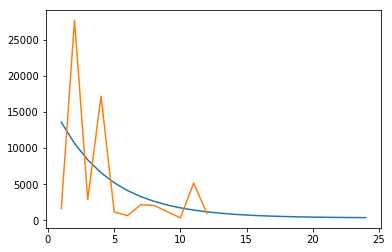

In [20]:
def plot_stat(trend, actual, stat):
    plt.plot(trend['transaction_month'], trend[stat])
    plt.plot(actual['transaction_month'], actual[stat])

trend = zdata.preprocessed.error_trend().groupby('transaction_month').mean().reset_index()
actual = zdata.preprocessed.error_month
plot_stat(trend, actual, 'logerror_percent_month_ave')

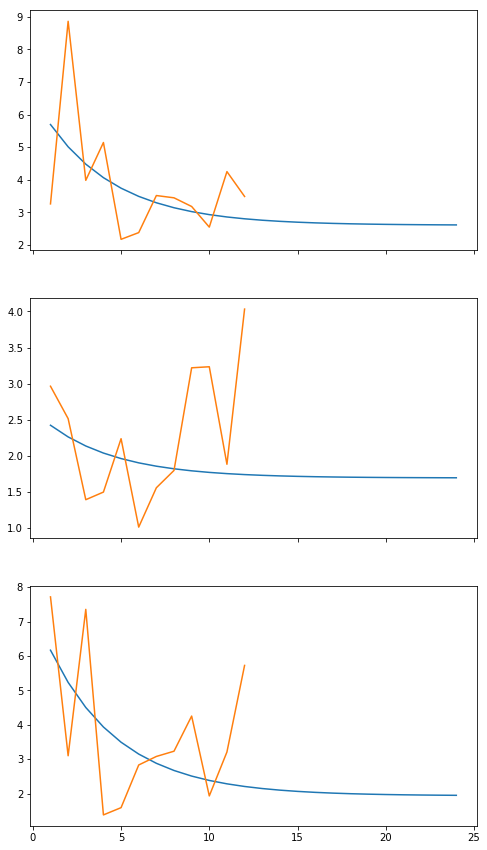

In [21]:
def plot_stat(trend, actual, stat, ax):
    ax.plot(trend['transaction_month'], trend[stat])
    ax.plot(actual['transaction_month'], actual[stat])

actual = zdata.preprocessed.error_fips_month
trend = zdata.preprocessed.error_trend()
ff, axes = plt.subplots(len(actual['fips'].unique()), sharex=True, figsize=(8,15))
for f, ax in zip(actual['fips'].unique(), axes):
    actual_fips = actual[actual['fips'] == f]
    trend_fips = trend[trend['fips'] == f]
    plot_stat(trend_fips, actual_fips, 'logerror_percent_fips_month_ave', ax)

0.17180730467250735

0.14327251133993027

0.13989326523193055

0.15865108328460498

0.13352731483737715

0.10840354639014932

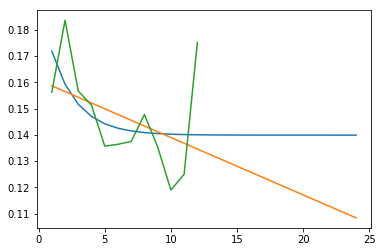

In [85]:
def plot(coefs):
    xs = range(1, 25)
    ys = [ coefs[0]*np.exp(-l*x)+coefs[1] for x in xs ]
    plt.plot(xs, ys)
    display(max(ys), np.mean(ys), min(ys))

def plot_linear(coefs):
    xs = range(1, 25)
    ys = [ coefs[0]*x+coefs[1] for x in xs ]
    plt.plot(xs, ys)
    display(max(ys), np.mean(ys), min(ys))
    
col = 'logerror_abs'
l = 0.5
coefs = np.polyfit(np.exp(-l*logerror_month['transaction_month']), logerror_month[col], 1)
plot(coefs)
coefs = np.polyfit(logerror_month['transaction_month'], logerror_month[col], 1)
plot_linear(coefs)
plt.plot(logerror_month['transaction_month'], logerror_month[col])

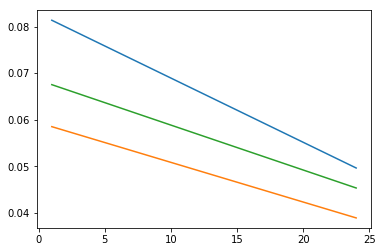

In [27]:
dl.logerror_fips_month
for f in dl.logerror_fips_month['fips'].unique():
    df = dl.logerror_fips_month[dl.logerror_fips_month['fips'] == f]
    plt.plot(df['transaction_month'], df['logerror_abs_fips_month_ave'])

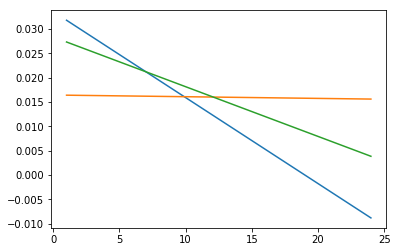

In [28]:
dl.logerror_fips_month
for f in dl.logerror_fips_month['fips'].unique():
    df = dl.logerror_fips_month[dl.logerror_fips_month['fips'] == f]
    plt.plot(df['transaction_month'], df['logerror_abs_fips_month_std'])

In [134]:
from zillow import *

In [10]:
zillow_data = DataLoader()
gc.collect()

349

In [92]:
def clr(epoch, lr_min=0.0001, lr_max=0.001, cycle=10):
    f = abs((epoch % cycle) - (cycle/2)) * 2 / cycle
    lr = lr_max - (lr_max - lr_min) * (1 - f)
    return lr

# for i in range(100):
#     print (clr(i))

clrs = keras.callbacks.LearningRateScheduler(clr)
mc = keras.callbacks.ModelCheckpoint('zillow/best_checkpoint.model', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
es = keras.callbacks.EarlyStopping(patience=20)
rlr = keras.callbacks.ReduceLROnPlateau(patience=1)

dropcols = set([
    'propertyzoningdesc', 
#    'propertycountylandusecode', 
    'censustractandblock', 
    'rawcensustractandblock',
#    'fips',
    'tractandblock',
    'roomcnt', 
    'bedroomcnt', 
    'taxdelinquencyflag',
    'taxdelinquencyyear',
])

nn = NeuralNet(zillow_data.preprocessed, dropcols=dropcols)
gc.collect()

334

In [93]:
nn.train(epochs=100, callbacks=[clrs, mc, es], verbose=1)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
architecturalstyletypeid_inp (In (None, 1)             0                                            
____________________________________________________________________________________________________
regionidcity_inp (InputLayer)    (None, 1)             0                                            
____________________________________________________________________________________________________
heatingorsystemtypeid_inp (Input (None, 1)             0                                            
____________________________________________________________________________________________________
propertycountylandusecode_inp (I (None, 1)             0                                            
___________________________________________________________________________________________

Train on 72158 samples, validate on 18117 samples
Epoch 1/100
 3584/72158 [>.............................] - ETA: 56s - loss: 0.1974

KeyboardInterrupt: 

In [80]:
nn.get_model().save_weights('zillow/0.065878423055811319.wgt')

In [94]:
nn.model = keras.models.load_model('zillow/best_checkpoint.wgt')
nn.test()

OSError: Unable to open file (Unable to open file: name = 'zillow/best_checkpoint.wgt', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [95]:
nn.model = keras.models.load_model('zillow/0.06564.model')
nn.model.summary()
nn.test()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
architecturalstyletypeid_inp (In (None, 1)             0                                            
____________________________________________________________________________________________________
regionidcity_inp (InputLayer)    (None, 1)             0                                            
____________________________________________________________________________________________________
heatingorsystemtypeid_inp (Input (None, 1)             0                                            
____________________________________________________________________________________________________
propertycountylandusecode_inp (I (None, 1)             0                                            
___________________________________________________________________________________________

0.065641815279478044

In [96]:
nn.predict()

Predicting... 201610
2985217/2985217 [==============================] - 1748s  


,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,-0.001329,-0.000543,0.000269,0.008086,0.008881,0.009745
1,10759547,-0.001574,-0.000820,-0.000006,0.008022,0.008818,0.009724
2,10843547,0.134220,0.133590,0.132912,0.125679,0.125206,0.124847
3,10859147,0.018415,0.018959,0.019369,0.023672,0.024511,0.025387
4,10879947,-0.051201,-0.050091,-0.048864,-0.034099,-0.032662,-0.031290
5,10898347,0.007533,0.008366,0.009145,0.017660,0.018737,0.019805
6,10933547,-0.001705,-0.000885,0.000024,0.009310,0.010286,0.011317
7,10940747,0.012630,0.013250,0.013843,0.020965,0.022000,0.022968
8,10954547,-0.002739,-0.002030,-0.001167,0.008384,0.009353,0.010333
9,10976347,0.012277,0.012595,0.012783,0.017663,0.018473,0.019373


# EDA

## Training, Properties and Submission Data

In [ ]:
dv = describe_values(dl.get_properties())

In [ ]:
dv[dv['missing %'] < 50]

In [ ]:
tx = 'transactiondate'
train = dl.get_training()
train = split_date(train, tx).drop(tx, axis=1)
train = train.pivot_table(columns='parcelid', index=['transactiondate_year', 'transactiondate_month'], values='logerror')
display(train)

In [ ]:
# how much data is missing?
display(train.isnull().sum().sum() / (train.shape[0]*train.shape[1]))

Most parcels have only 1 data point. Too much missing data to be useful on a per parcel basis.

In [ ]:
prop_parcels = set(dl.get_properties()['parcelid'])
subm_parcels = set(dl.get_submission()['ParcelId'])
trxn_parcels = set(dl.get_training()['parcelid'])
prp = dl.get_properties()
nodt_parcels = set(prp.loc[prp.rawcensustractandblock.isnull(), 'parcelid'])

# Are all properties required in the submission?
display(len(prop_parcels - subm_parcels) == 0)

# Do all properties have recorded transactions?
display(len(prop_parcels - trxn_parcels) == 0)

# How much of the submission is missing?
display(len(subm_parcels - trxn_parcels))

print(len(nodt_parcels & trxn_parcels), 'parcels have no data but have transactions')

Also some parcels have no property data!

## Logerror

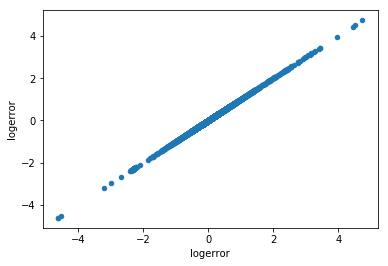

In [8]:
# check for outliers
pd.DataFrame(dl.get_training_preprocessed()['logerror']).plot.scatter(x='logerror', y='logerror')

In [ ]:
summarize(pd.DataFrame(dl.get_training()['logerror']))

In [13]:
# see if logerror varies per month

txm = 'transaction_month'
df = dl.get_training_preprocessed()

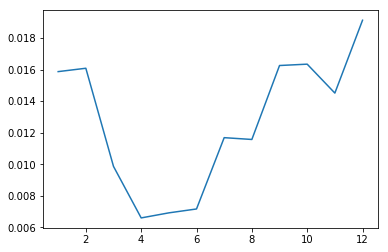

In [14]:
monthly = df[[txm, 'logerror']].groupby([txm])['logerror'].mean()
plt.plot(monthly.index, monthly)

In [ ]:
monthly = df[[txm, 'abs_logerror']].groupby([txm])['abs_logerror'].mean()
plt.ylim(0.06, 0.08)
plt.plot(monthly.index, monthly)

In [ ]:
def plot_monthly(df, grp, val):
    monthly = df.groupby([grp, txm])[val].mean()
    figs = len(monthly.index.levels[0])
    f, axes = plt.subplots(figs, 1, figsize=(8, figs*4), sharex=True, sharey=True)
    for g, ax in zip(monthly.index.levels[0], axes):
        plt.subplot(ax)
        plt.plot(monthly[g].index, monthly[g])

In [ ]:
plot_monthly(df, 'fips', 'logerror')

In [ ]:
plot_monthly(df, 'fips', 'abs_logerror')

In [ ]:
plot_monthly(df, 'regionidcounty', 'abs_logerror')

In [ ]:
monthly = df[[txm, 'abs_logerror']].groupby([txm])['abs_logerror'].mean()
monthly = monthly.reset_index()

In [ ]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha = .5)
reg.fit(monthly.drop('abs_logerror', axis=1), monthly['abs_logerror'])
preds = pd.DataFrame([ i for i in range(24)])
preds['abs_logerror'] = reg.predict(preds)

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(monthly.index, monthly['abs_logerror'])
plt.plot(preds.index, preds['abs_logerror'])

In [ ]:
sns.lmplot(x=txm, y="abs_logerror", data=monthly, ci=None, palette="muted")

In [ ]:
from sklearn import linear_model
lm = linear_model.Ridge(alpha = .5)

def regress(df, val):
    monthly = df.groupby(['fips', 'age'])[val].mean()
    preds = pd.DataFrame()
    for f in monthly.index.levels[0]:
        fip = monthly[f].reset_index()
        lm.fit(fip.drop(val, axis=1), fip[val])
        next_months = pd.DataFrame([ i for i in range(13, 25)], columns=['age'])
        next_months[val] = lm.predict(next_months)
        next_months['fips'] = f
#         display(next_months)
        preds = preds.append(next_months)
    preds = preds.append(monthly.reset_index())
    display(preds)

regress(df, 'abs_logerror')